# この課題の目的
・コーディング力を向上させる  
・全体の構造を意識したコーディングをする  
・スクラッチを通してK-meansを理解する  
・クラスタ分析を行う  

## 課題を実施した所感（2018/11/13（火））
・今回のK-meansは人のコードを見ないで、自分で全部かけたことが自信になりました（動きましたが、色々イケてないと思いますが）。小規模データの方で、K-meansのクラスを作成出来て、エルボー図を描画出来た時は、達成感を得ることが出来ました。ただ、スクラッチで作成したクラスのソースコードで作法などで誤っている箇所がありましたらご指摘いただきたいです。  

・大分、K-meansを理解が出来たと思います。ただ、K-means法は弱点（楕円などの横長の散布は分析出来ない）があるので、業務での利用のイメージがまだあまり沸いていないのが正直なところです。

**実施出来ていないこと**  
・シルエット図  
・pyファイル化  
・EDAは記載しましたが、突っ込んで取り組めておりません（スクラッチに時間が掛かったため）


# まず、小規模データセットで進める

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

#　n_samples:サンプル数
# n_features：特徴量（説明変数）の数
# centers:クラスタの数　
# cluster_std:クラスタ内の標準偏差（ばらつき度合い）　
# shuffle:サンプルをシャッフル　
# random_state:乱数生成を固定

X, _ = make_blobs(n_samples =100,\
                  n_features=2, \
                  centers=4, \
                  cluster_std=0.5, \
                  shuffle=True, \
                  random_state=0)


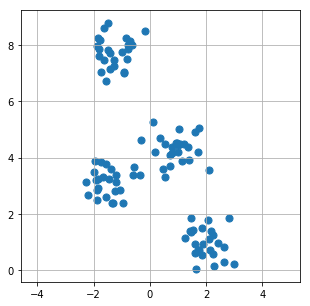

In [2]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], marker='o', s=50)
plt.axis('equal')
plt.grid()
plt.show()

# K-means法のスクラッチ
この中で、推定も実施している

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# K-meansのクラス
class ScratchKMeans:
    
    def __init__(self, cluster, iteration):
        self.cluster = cluster
        self.iteration = iteration

    
    # 中心点表を作成する関数
    def _get_center_point(self, X):
        
        # 中心点表を初期化する
        self.center_point_list = []

        for i in np.unique(self.label):

            # X0軸方向の平均
            X0_sum = X[self.label == i][:, 0].sum()
            X0_cnt = len(X[self.label == i])
            X0_point = X0_sum / X0_cnt

            # X1軸方向の平均
            X1_sum = X[self.label == i][:, 1].sum()
            X1_cnt = len(X[self.label == i])
            X1_point = X1_sum / X1_cnt

            # 中心点（重心）を求める
            center_point = [X0_point, X1_point]

            # 中心点表を作成（更新）する
            self.center_point_list.append(center_point)
    
    # 中心点と全データとの距離を求める関数
    def _get_distance(self, X):
        
        # 中心点表を更新
        self._get_center_point(X)
        
        # 距離表の枠を作成
        distance_list = np.zeros((len(X), len(self.center_point_list)))
        
        for i, values in enumerate(self.center_point_list):

            # 重心と全データとの距離表を作成
            for j in range(len(X)):
                
                diff = values - X[j]
                distance = np.linalg.norm(diff)
                distance_list[j, i] = distance
                
        return distance_list
    
    # 学習する
    def fit(self, X):
        
        self.label = np.random.randint(0, self.cluster, len(X))
        
        # 全データの一番近いクラスタラベルをゲット出来たので、
        # 新しいクラスラベルの値へ、古いクラスラベルを更新してあげる
        for i in range(self.iteration):
            
            # 距離表で、それぞれのXで最初のクラスラベルのインデックスを取得
            # そのインデックスは、クラスタラベルに等しい
            self.label = np.argmin(self._get_distance(X), axis=1)
            
            # 今時点の中心点を保持しておく
            pre_center_point_list = self.center_point_list
            
            # クラスタラベルを最新
            self.label = np.argmin(self._get_distance(X), axis=1)
            
            # 収束判定に用いる許容可能誤差を追加
            diff_sum = 0.0
            for i in range(len(self.center_point_list)):
                diff = [x-y for (x,y) in zip(self.center_point_list[i], pre_center_point_list[i])]
                diff_sum = diff_sum + np.linalg.norm(diff)
 
            if diff_sum < 0.0001:
                break

            # 前後で中心点を比較
            if pre_center_point_list == self.center_point_list:
                #print("---学習終了しました---",i*2,"イテレーション回数")
                break
    
    # エルボー法 誤差平方和SSE
    # 重心座標はfitで取得出来ているので、それを使って、
    # クラスタ数が変化した時のSSEの変化度を取得する関数
    def elbow(self, X, cluster):
        self.cluster = cluster
        self.label = np.random.randint(0, self.cluster, len(X))
        
        # SSE_list
        sse_list = []
        
        # クラスタ数をパラメータとしてfitさせる
        for n in range(self.cluster):
            
            self.cluster = n + 1
            
            # クラスタラベルを作成
            self.label = np.random.randint(0, self.cluster, len(X))
            
            # 学習
            self.fit(X)
        
            # |Xn - μk||**2の枠を作成
            elbow_list = np.zeros((len(X), len(self.center_point_list)))
            
            for i, values in enumerate(self.center_point_list):

                # ||Xn - μk||**2の表を作成する
                for j in range(len(X)):    
                    elbow_diff = X[j] - values
                    
                    # ドット積でやり方
                    #elbow_list[j, i] = np.dot(elbow_diff, elbow_diff.T)
                    
                    # ノルムを取って二乗するやり方
                    elbow_list[j, i] = np.linalg.norm(elbow_diff)**2

            # 最小値を取得
            elbow_list_min = elbow_list.min(axis=1)

            # SSEを算出
            sse = elbow_list_min.sum()
            sse_list.append(sse)
            
        return sse_list

# インスタンス生成し、学習

In [4]:
# クラスを実行
skm = ScratchKMeans(cluster=4, iteration = 10)
skm.fit(X)
skm.center_point_list

[[-1.4793567922695052, 3.117168961022598],
 [1.9918690296485415, 0.9656107096107793],
 [-1.2681173257461036, 7.763782656002402],
 [0.9257844652071338, 4.324757919503758]]

# sklearnと比較

In [5]:
# sklearnの K-means法の結果と比較　。結果は同じであった
from sklearn.cluster import KMeans
km  = KMeans(n_clusters=4, random_state=0)
km.fit(X)
km.cluster_centers_

array([[-1.47935679,  3.11716896],
       [-1.26811733,  7.76378266],
       [ 1.99186903,  0.96561071],
       [ 0.92578447,  4.32475792]])

# エルボー法を描画する

In [6]:
skm2 = ScratchKMeans(cluster=4, iteration = 10)
skm2.elbow(X, 10)
sse = skm2.elbow(X, 10)

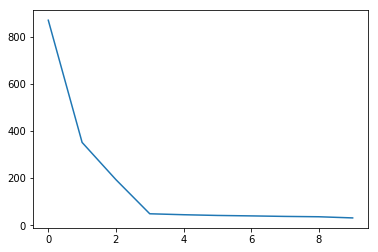

In [7]:
# 上手く描画出来た！　やったー！
plt.plot(range(0,10), sse)
plt.show()

# 結果の可視化

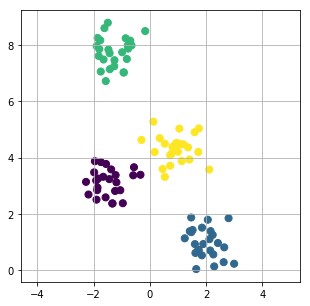

In [26]:
# うまく中心点（重心）を得られていたようだ！
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=skm.label, marker='o', s=50)
plt.axis('equal')
plt.grid()

# Wholesale customers について

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# データセットのダウンロード（リスボンの卸売業者）
# https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

data = pd.read_csv("/Users/tsuneo/git/diveintocode-term1/Wholesale customers data.csv")

## EDA。。。

In [11]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [12]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


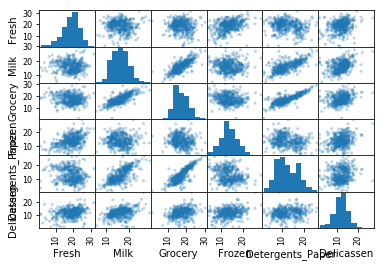

In [28]:
from  pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.3)
plt.show()

In [14]:
data.shape

(440, 8)

In [15]:
# 2変数をドロップする
data = data.drop(["Channel", "Region"], axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [16]:
data.shape

(440, 6)

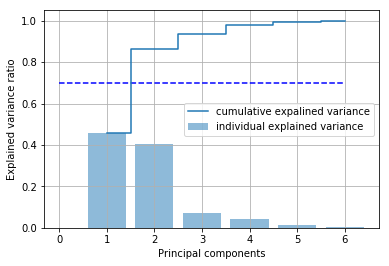

In [17]:
# # PCAの分散説明率を表示するコード
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 前処理

In [18]:
# 正規化
from scipy import stats
from scipy.stats import norm, skew #for some statistics

skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data[feat] = boxcox1p(data[feat], lam)


Skew in numerical features: 

There are 6 skewed numerical features to Box Cox transform


In [19]:
# 名義尺度のChannel,Region以外の６個の特徴量を２個に減らす
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

## 描画してみる
散らばっていることを確認

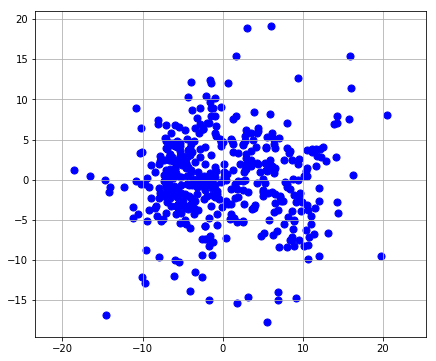

In [20]:
plt.figure(figsize=(7, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='b', marker='o', s=50)
plt.axis('equal')
plt.grid()
plt.show()

## 自作のK-meansクラスにWholesaleデータを食わせて、エルボー図を描画してみる

In [21]:
skm3 = ScratchKMeans(cluster=4, iteration = 10)
skm3.elbow(data_pca, 20)
sse3 = skm2.elbow(data_pca, 20)

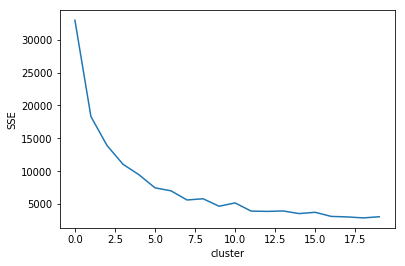

In [22]:
# 上手く描画出来た！！
plt.plot(range(0,20), sse3)
plt.xlabel("cluster")
plt.ylabel("SSE")
plt.show()

# クラスタ数kの選択
最適だと思われるクラスタ数kを選択せよ。エルボー法とシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってくる。選択した上で、なぜそれを選んだか説明せよ。

**【回答】**  
エルボー法から3〜4個のクラスタが適切ではないかと思います。


# 既知のグループとの比較
名義尺度であるためRegionとChannelはK-meansに使用しなかったが、これれらは既知のグループである。クラスタとこれら既知のグループがどう違うかを確認し、説明せよ。まずはそれぞれを可視化すること。

**【回答】**  

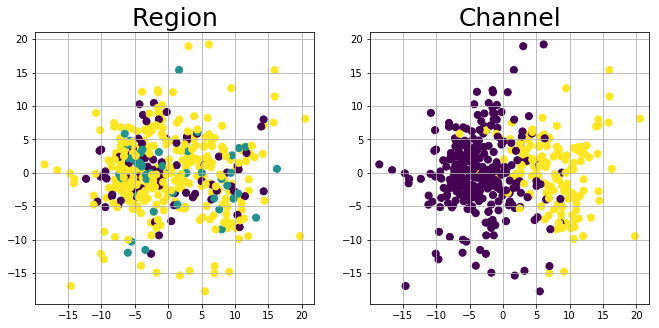

In [23]:
# 【回答】
Data = pd.read_csv("/Users/tsuneo/git/diveintocode-term1/Wholesale customers data.csv")
Data_Region = Data.Region
Data_Channel = Data.Channel

# 左図はRegionですが、相関はなさそうです。
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=Data_Region, marker='o', s=50)
plt.axis('equal')
plt.title("Region", fontsize=25)
plt.grid()

# 右図はChannelですが、相関があることがわかります。２つのクラスタに分類しているようです。
plt.subplot(1, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=Data_Channel, marker='o', s=50)
plt.axis('equal')
plt.title("Channel", fontsize=25)
plt.grid()
plt.show()


In [24]:
# Channelの値を確認
set(Data_Channel)

{1, 2}

# 卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめる。クラスタ分析が一般的にどう行われているのかを調べても良い。  

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどする。また、PCAで次元削減したデータに対してK-meansを使用したが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみる。既知のグループとの比較結果も参考にする。  

条件ごとにデータを見る際にはpandasのgroupbyが便利である。

**【回答】** 

In [25]:
# 【回答】
# Channelとの相関があることがわかったため、groupbyで平均を取得してみる。
Data_all = pd.read_csv("/Users/tsuneo/git/diveintocode-term1/Wholesale customers data.csv")

Data_all.groupby(["Channel"]).mean()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,2.510067,13475.560403,3451.724832,3962.137584,3748.251678,790.560403,1415.956376
2,2.612676,8904.323944,10716.500000,16322.852113,1652.612676,7269.507042,1753.436620


# 説明

## **【クラスタリングとは何か】**  
教師なし学習によ理、「クラスタ」と呼ばれるグループに分割するタスクです。与えられたデータを外的基準なしに自動的に分類する手法です。  


## **【K-meansとは何か】**   
サンプルデータのある領域を代表するようなクラスタ重心を見つけようとするアルゴリズムです。今回は以下の手順でK-meansをスクラッチでコーディングしました。  

**ステップ①**　最初は,全データに対してクラスタリングラベルをランダムに割り当てる  
            その際、クラスタリングラベルの個数（k）は人間が指定する  
            
**ステップ②**　その次に、クラスタ毎のセンタ（重心・中心）を算出したいので、「ランダムに振ったクラスタラベル」毎にクラスタセンタ（重心＝平均座標軸）を算出する  

**ステップ③**　②で算出したクラスタセンタ（重心）と、全データの距離を算出して、全データは一番近いクラスタセンタに属するようにデータ自身が保持するクラスタリングラベルを更新する  

**ステップ④**　②③を繰り返し、クラスタセンタ（重心＝平均座標軸）が変わらないまでループする  


## **【クラスタ分析について】**  
クラスター分析とは、異なるものが混ざりあっている集団の中から互いに似たものを集めて集落（クラスター）を作り、対象を分類するという方法の総称です。簡単にいえば「似たもの集めの手法」です。  

クラスター分析は、あらかじめ分類の基準が決まっておらず、分類のための外的基準や評価が与えられていない「教師無しの分類法」です。従って、データを単純に男女別や年代別に分けた塊をクラスターとは呼びません。

<参考URL>  
https://www.albert2005.co.jp/knowledge/data_mining/cluster/cluster_summary

## **【中心点の初期値についてランダム以外にはどのようなものがあるか】**  
**KKZ法**  
Katsavounidis ら (1994) によって提案され、初期のクラスタ中心として，最も離れているデータ同士をクラスタ中心の初期値として選択する手法である。

**k-means++**  
David Arthur によって提案された，近年最も注目されている k-means 法の初期値設定手法である．この方法は，KKZ 法の外れ値に弱いといった特性を改良したものである。

<参考URL>   
https://www.jstage.jst.go.jp/article/fss/27/0/27_0_55/_pdf

## **【クラスタ数の決め方について】**  
クラスタ数を決める判断方法としてエルボー法があります。SSE（クラスタ内誤差平方和（SSE, Sum of Squared Errors））を縦軸、クラスタ数kを横軸にした折れ線グラフです。クラスタ数の増加に伴い、SSEが急激に下がって、曲線がなだらかになるあたりのクラスタ数を最適として決める方法です。他にはシルエット法があります。